In [189]:
import folium
import requests
import pandas as pd
import numpy as np

In [190]:
# ref : https://github.com/infoBMKG/data-gempabumi

autogempa = "https://data.bmkg.go.id/DataMKG/TEWS/autogempa.json"
gempabumiterkini = "https://data.bmkg.go.id/DataMKG/TEWS/gempaterkini.json"
gempabumidirasakan = "https://data.bmkg.go.id/DataMKG/TEWS/gempadirasakan.json"

# Function

In [191]:
class StoreBMKG():
    def __init__(self, data: str):
        self.__get_bmkg(data)

    def __auto_earthquake(self, filename, data: dict):
        data = pd.DataFrame.from_dict(data, orient='index').T
        data.to_csv('dataset/'+filename+'.csv', index=True)

    # need to improve table for more tidy csv from felt to new
    def __felt_earthquake(self, filename, data: pd.DataFrame):
        columns = ['Tanggal','Jam','DateTime','Coordinates','Lintang','Bujur','Magnitude','Kedalaman','Wilayah', 'Dirasakan']

        rows = []
        for d in data:
            rows.append(pd.Series(d, index=columns))
        
        datas = pd.DataFrame(rows, columns=columns)
        datas.to_csv('dataset/'+filename+'.csv', index=True)
            
    def __new_earthquake(self, filename, data: pd.DataFrame):
        columns = ['Tanggal','Jam','DateTime','Coordinates','Lintang','Bujur','Magnitude','Kedalaman','Wilayah', 'Potensi']

        rows = []
        for d in data:
            rows.append(pd.Series(d, index=columns))
        
        datas = pd.DataFrame(rows, columns=columns)
        datas.to_csv('dataset/'+filename+'.csv', index=True)

    def __get_bmkg(self, data:str):

        from io import StringIO
        
        try:
            headers = {
                'User-Agent': 'Mozilla/5.0 \
                    (Macintosh; Intel Mac OS X 10_11_5) \
                    AppleWebKit/537.36 (KHTML, like Gecko) \
                    Chrome/50.0.2661.102 Safari/537.36'
            }
            
            response = requests.get(data, headers=headers)
            raw = pd.read_json(StringIO(response.content.decode('utf-8')))
            
            filename = data.split('/')[-1].split('.')[0]

            if filename == 'autogempa':
                self.__auto_earthquake(filename, raw['Infogempa']['gempa'])
            elif filename == 'gempadirasakan':
                self.__felt_earthquake(filename, raw['Infogempa']['gempa'])
            elif filename == 'gempaterkini':
                self.__new_earthquake(filename, raw['Infogempa']['gempa'])
                
        except requests.exceptions.HTTPError as errh:
            print(repr(errh))
        except requests.exceptions.ConnectionError as errc:
            print(repr(errc))
        except requests.exceptions.Timeout as errt:
            print(repr(errt))
        except requests.exceptions.RequestException as err:
            print(repr(err))

# Storing Data into CSV

In [192]:
listDataBMKG = [autogempa, gempabumidirasakan, gempabumiterkini]
for d in listDataBMKG:
    StoreBMKG(d)

# Data BMKG Gempa

## Show Table

In [193]:
dataAutoGempa = pd.read_csv('dataset/autogempa.csv')

dataAutoGempa.drop(dataAutoGempa.columns[
    dataAutoGempa.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

display(dataAutoGempa)

,Tanggal,Jam,DateTime,Coordinates,Lintang,Bujur,Magnitude,Kedalaman,Wilayah,Potensi,Dirasakan,Shakemap
0,26 Mar 2024,00:36:36 WIB,2024-03-25T17:36:36+00:00,"0.83,125.40",0.83 LU,125.40 BT,4.8,40 km,Pusat gempa berada di laut 71 km Tenggara Ratahan,Gempa ini dirasakan untuk diteruskan pada masy...,"II-III Bitung, II Manado, II Tondano",20240326003636.mmi.jpg


## Show Map

### Folium

In [194]:
import math

def find_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(float(lat2)-lat1)
    dlon = math.radians(float(lon2)-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(float(lat2))) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance_bw_ori_desti = radius * c
    return distance_bw_ori_desti

In [204]:
# ref : https://www.instrovate.com/2019/07/01/tagging-two-locations-on-map-using-python-and-finding-distance-between-two-tagged-location-in-python/

from collections import namedtuple

def getArrows(locations, color='blue', size=6, n_arrows=3):

    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    point1 = Point(locations[0][0], locations[0][1])
    point2 = Point(float(locations[1][0]), float(locations[1][1]))
    
    angle = get_angle(point1, point2) - 90
    
    arrow_latitude = np.linspace(point1.lat, point2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_longitude = np.linspace(point1.lon, point2.lon, n_arrows + 2)[1:n_arrows+1]
    
    final_arrows = []
    
    for points in zip(arrow_latitude, arrow_longitude):
        final_arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=angle))
    return final_arrows

def get_angle(p1, p2):

    longitude_diff = np.radians(float(p2.lon) - p1.lon)
    
    latitude1 = np.radians(p1.lat)
    latitude2 = np.radians(float(p2.lat))
    
    x_vector = np.sin(longitude_diff) * np.cos(latitude2)
    y_vector = (np.cos(latitude1) * np.sin(latitude2) 
        - (np.sin(latitude1) * np.cos(latitude2) 
        * np.cos(longitude_diff)))
    angle = np.degrees(np.arctan2(x_vector, y_vector))
    
    if angle < 0:
        return angle + 360
    return angle

In [213]:
quake = [0, 0]
surabaya = [-7.2754417, 112.6302827]

for v in dataAutoGempa['Coordinates'].values:
    quake = v.split(',')

centerlat = (float(quake[0]) + float(quake[1])) / 2
centerlon = (surabaya[0] + surabaya[1]) / 2

map = folium.Map(location=[centerlat, centerlon], zoom_start=7)

estimated_distance = find_distance(surabaya, quake)
print(f"Estimated distance: {estimated_distance:.2f} kilometers")

html=f"""
        <span style="size: 10px; background-color: lightblue; ">
        <p> distance of surabaya and quake {estimated_distance}</p></span>
        """
iframe = folium.IFrame(html=html, width=130, height=130)
popup = folium.Popup(iframe, max_width=165)

folium.Marker(quake).add_to(map)
folium.Marker(surabaya).add_to(map)
folium.PolyLine(popup=popup, locations=[surabaya, quake], color='red').add_to(map)

arrows = getArrows(locations=[surabaya, quake], n_arrows=7)

for arrow in arrows:
    arrow.add_to(map)

map


Estimated distance: 1678.90 kilometers


# Data BMKG Gempa Dirasakan

In [251]:
datafeltquake = pd.read_csv('dataset/gempadirasakan.csv')

datafeltquake.drop(datafeltquake.columns[
    datafeltquake.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

display(datafeltquake)

,Tanggal,Jam,DateTime,Coordinates,Lintang,Bujur,Magnitude,Kedalaman,Wilayah,Dirasakan
0,26 Mar 2024,00:36:36 WIB,2024-03-25T17:36:36+00:00,"0.83,125.40",0.83 LU,125.40 BT,4.8,40 km,Pusat gempa berada di laut 71 km Tenggara Ratahan,"II-III Bitung, II Manado, II Tondano"
1,25 Mar 2024,20:54:19 WIB,2024-03-25T13:54:19+00:00,"-5.66,112.41",5.66 LS,112.41 BT,4.0,10 km,Pusat gempa berada dilaut 143 km Timur Laut Tuban,II-III Bawean
2,25 Mar 2024,20:40:50 WIB,2024-03-25T13:40:50+00:00,"-5.47,105.24",5.47 LS,105.24 BT,2.0,3 km,Pusat gempa berada di darat 3 Km BaratDaya Ban...,II Teluk Betung
3,25 Mar 2024,20:21:38 WIB,2024-03-25T13:21:38+00:00,"-4.64,120.38",4.64 LS,120.38 BT,3.6,7 km,Pusat gempa berada di darat 36 km Timur Laut Bone,"III Watampone, III Mare, III Sibulue"
4,25 Mar 2024,19:37:05 WIB,2024-03-25T12:37:05+00:00,"-1.58,120.21",1.58 LS,120.21 BT,4.4,10 km,Pusat gempa berada di darat 17 km Utara Doda,"III Lore Utara, III Lore Peore, II-III Kulawi"
5,25 Mar 2024,18:54:24 WIB,2024-03-25T11:54:24+00:00,"1.14,113.00",1.14 LU,113.00 BT,4.3,10 km,Pusat gempa berada di darat 34 km Barat Laut K...,"III Kapuas Hulu, III Putusibau"
6,25 Mar 2024,02:55:07 WIB,2024-03-24T19:55:07+00:00,"4.10,96.88",4.10 LU,96.88 BT,4.1,3 km,Pusat gempa berada di darat 30 km BaratLaut Bl...,II-III Gayo Lues
7,25 Mar 2024,02:49:06 WIB,2024-03-24T19:49:06+00:00,"4.26,96.86",4.26 LU,96.86 BT,4.9,4 km,Pusat gempa berada di darat 40 km Tenggara Tak...,II-III Gayo Lues
8,24 Mar 2024,22:34:06 WIB,2024-03-24T15:34:06+00:00,"-7.84,108.62",7.84 LS,108.62 BT,4.7,80 km,Pusat gempa berada di laut 20 km Tenggara Kabu...,"III Pangandaran, II-III Tasikmalaya, II-III Ci..."
9,24 Mar 2024,20:19:01 WIB,2024-03-24T13:19:01+00:00,"-8.22,115.61",8.22 LS,115.61 BT,3.5,10 km,Pusat gempa berada di laut 17 km TimurLaut Kar...,II Karangasem


<Axes: title={'center': 'magnitude for 14 days'}>

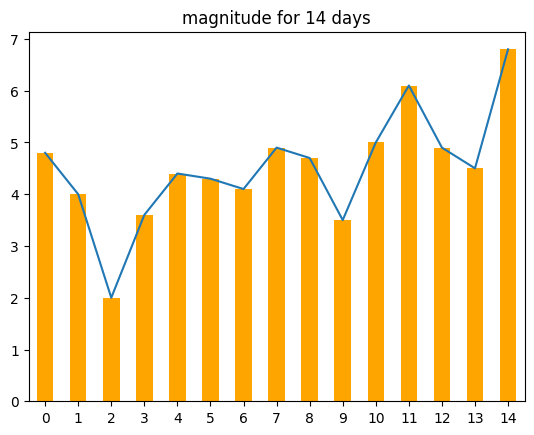

In [268]:
datafeltquake['Magnitude'].plot(kind="bar", color='orange', title="magnitude for 14 days")
datafeltquake['Magnitude'].plot(kind="line", title="magnitude for 14 days")

# Data BMKG Gempa Terkini

In [214]:
datanewquake = pd.read_csv('dataset/gempaterkini.csv')

datanewquake.drop(datanewquake.columns[
    datanewquake.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

display(datanewquake)

,Tanggal,Jam,DateTime,Coordinates,Lintang,Bujur,Magnitude,Kedalaman,Wilayah,Potensi
0,24 Mar 2024,18:53:55 WIB,2024-03-24T11:53:55+00:00,"-1.53,133.36",1.53 LS,133.36 BT,5.0,27 km,65 km BaratLaut TELUKBINTUNI-PAPUABRT,Tidak berpotensi tsunami
1,24 Mar 2024,10:04:10 WIB,2024-03-24T03:04:10+00:00,"-9.64,122.16",9.64 LS,122.16 BT,6.1,47 km,104 km Tenggara ENDE-NTT,Tidak berpotensi tsunami
2,23 Mar 2024,20:20:29 WIB,2024-03-23T13:20:29+00:00,"-4.66,102.72",4.66 LS,102.72 BT,5.6,27 km,31 km BaratDaya BENGKULUSELATAN,Tidak berpotensi tsunami
3,22 Mar 2024,15:52:58 WIB,2024-03-22T08:52:58+00:00,"-5.76,112.33",5.76 LS,112.33 BT,6.5,10 km,130 km TimurLaut TUBAN-JATIM,Tidak berpotensi tsunami
4,22 Mar 2024,12:31:12 WIB,2024-03-22T05:31:12+00:00,"-5.74,112.36",5.74 LS,112.36 BT,5.3,10 km,133 km TimurLaut TUBAN-JATIM,Tidak berpotensi tsunami
5,22 Mar 2024,11:22:45 WIB,2024-03-22T04:22:45+00:00,"-5.74,112.32",5.74 LS,112.32 BT,6.0,10 km,132 km TimurLaut TUBAN-JATIM,Tidak berpotensi tsunami
6,21 Mar 2024,07:19:14 WIB,2024-03-21T00:19:14+00:00,"-1.83,137.50",1.83 LS,137.50 BT,5.4,10 km,79 km BaratLaut KASONAWEJA-PAPUA,Tidak berpotensi tsunami
7,20 Mar 2024,15:24:57 WIB,2024-03-20T08:24:57+00:00,"-2.09,100.44",2.09 LS,100.44 BT,5.3,21 km,83 km BaratDaya PESISIRSELATAN-SUMBAR,Tidak berpotensi tsunami
8,18 Mar 2024,06:41:41 WIB,2024-03-17T23:41:41+00:00,"4.90,127.33",4.90 LU,127.33 BT,5.1,107 km,31 km TimurLaut PULAUKARATUNG-SULUT,Tidak berpotensi tsunami
9,14 Mar 2024,01:56:14 WIB,2024-03-13T18:56:14+00:00,"-0.21,125.24",0.21 LS,125.24 BT,6.2,10 km,128 km Tenggara TUTUYAN-BOLTIM-SULUT,Tidak berpotensi tsunami


<Axes: title={'center': 'magnitude for 14 days'}>

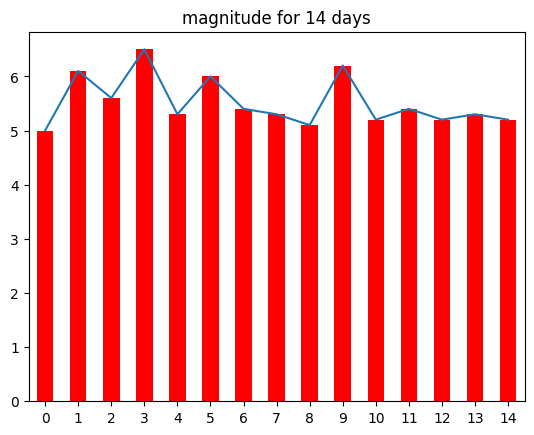

In [266]:
datanewquake['Magnitude'].plot(kind="bar", color='r', title="magnitude for 14 days")
datanewquake['Magnitude'].plot(kind="line", title="magnitude for 14 days")